In [1]:
%matplotlib inline


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import xbout
import scipy
import xhermes

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *
from soledge.wrapper_class import SOLEDGEcase

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


In [2]:
db = CaseDB()

toload = [ 
    dict(name="1e19", id="d45a-d42acb_1e19", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="2e19", id="d42acb-with_guards", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="3e19", id="d44a-d42acb_3e19", unnormalise_geom = True, use_xhermes = True, squash = True), 
    # dict(name="2e19_lores", id="t9b-nonortho_xpoint_afn", unnormalise_geom = True, use_xhermes = True, squash = True), 
    
    # dict(name="2e19_lores_clim1.0", id="upst7b-clim_1.0", unnormalise_geom = True, use_xhermes = True, squash = True), 
    # dict(name="2e19_lores_clim1.0_mfp1.0", id="upst7c-clim_1.0_maxmfp_1", unnormalise_geom = True, use_xhermes = True, squash = True), 

]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)
    cs[case["name"]].extract_2d_tokamak_geometry()


- Reading case d45a-d42acb_1e19
-----------------------
- Looking for squash file
- Squash file found. squash date 09/10/2024, 15:25:51, dmp file date 09/10/2024, 12:44:06


c:\Users\mikek\pyenvs\fusion-3.13\Lib\site-packages\xbout\load.py:1124: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case d42acb-with_guards
-----------------------
- Looking for squash file
- Squash file found. squash date 09/03/2024, 10:49:23, dmp file date 09/03/2024, 10:28:10


c:\Users\mikek\pyenvs\fusion-3.13\Lib\site-packages\xbout\load.py:1124: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case d44a-d42acb_3e19
-----------------------
- Looking for squash file
- Squash file found. squash date 09/10/2024, 15:27:45, dmp file date 09/10/2024, 12:48:53


c:\Users\mikek\pyenvs\fusion-3.13\Lib\site-packages\xbout\load.py:1124: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


## Calculating mean free path


$$l = \frac{1}{\sigma N}$$
$$ K = \sigma v_{rel}, \nu = K N $$
$$ \sigma = \frac{\nu}{Nv_{rel}} $$
$$ l = \frac{1}{N} \times \frac{Nv_{rel}}{\nu} = \frac{v_{rel}}{\nu}$$

In the perpendicular $v_{rel}$ can be $v_{th}^{i} + v_{th}^{n}$

In the parallel we have the relative velocity already

In [3]:
ds = cs["2e19"].ds.isel(t=-1).squeeze()

Mi = constants("mass_p") *2
qe = constants("q_e")

Ta = ds["Td"].values
Ti = ds["Td+"].values
Ne = ds["Ne"].values
Na = ds["Nd"].values
Vi = ds["Vd+"]
Va = ds["NVd"] / (ds["Nd"] * Mi)
Pd = ds["Pd"].values

ln_sigmav = -18.5028
Teff = (Ta + Ti)/2
lnT = np.log(Teff)
lnT_n = lnT.copy()

for b in [0.3708409, 7.949876e-3, -6.143769e-4, -4.698969e-4, -4.096807e-4, 1.440382e-4, -1.514243e-5, 5.122435e-7]:
    ln_sigmav += b * lnT_n
    lnT_n *= lnT
    
nu_cx = np.exp(ln_sigmav) * 1e-6 * Ne # convert from cm^3/s to m^3/s
nu_iz = ds["Sd+_iz"] / ds["Nd"]
nu = nu_cx + nu_iz  # Only consider CX for now
v_thi = 0.25 * np.sqrt((8 * ds["Td+"]*qe) / (np.pi * Mi))
v_thn = 0.25 * np.sqrt((8 * ds["Td"]*qe) / (np.pi * Mi))
mfp = v_thn / nu
ds["srad"] =  ds["dr"].cumsum("x")

dPd_dx = ds["Pd"].differentiate("x")          # ∂Pd/∂x |θ
dNd_dx = ds["Nd"].differentiate("x")
dTd_dx = ds["Td"].differentiate("x")
dsdx   = ds["srad"].differentiate("x")        # ∂s/∂x |θ

dPd_ds = dPd_dx / dsdx                         # ∂Pd/∂s |θ
dNd_ds = dTd_dx / dsdx 
dTd_ds = dTd_dx / dsdx 

L_Pd_rad = ds["Pd"] / dPd_ds
L_Nd_rad = ds["Nd"] / dNd_ds
L_Td_rad = ds["Td"] / dTd_ds

Kn_adv_rad = abs(mfp / L_Pd_rad)

ds["Kn_adv_rad"] = xr.DataArray(Kn_adv_rad, coords = ds["Ne"].coords)

ds["Kn_adv_rad"] = xr.DataArray(Kn_adv_rad, coords = ds["Ne"].coords)
# Kn_pol = abs(mfp / L_T_pol)

In [6]:
%matplotlib widget

In [9]:
%matplotlib inline

In [8]:
plt.close("all")

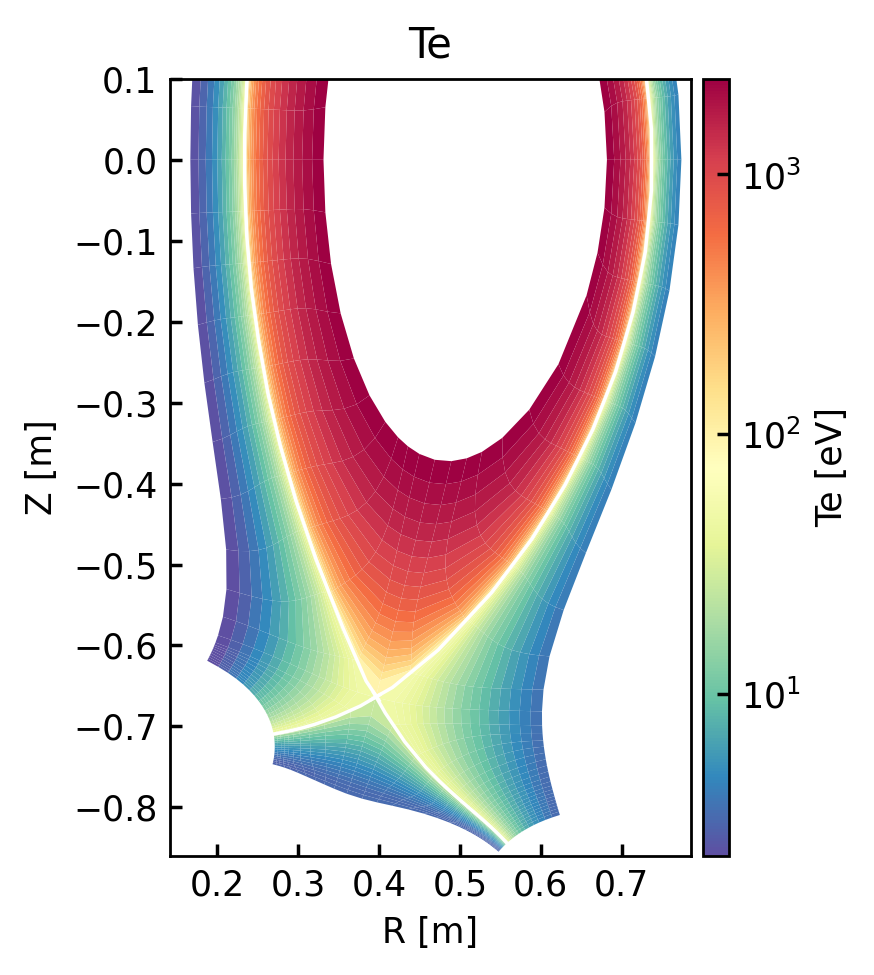

In [10]:
fig, ax = plt.subplots(dpi = 250)
ds["Te"].hermesm.clean_guards().bout.polygon(
    ax = ax, cmap = "Spectral_r", antialias = True,
    separatrix_kwargs = {"lw":1, "linestyle":"-", "color":"white"},
    # vmin = 1e-1, vmax = 1e1,
    logscale = True)

fig.tight_layout()
ax.set_ylim(-0.86, 0.1)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

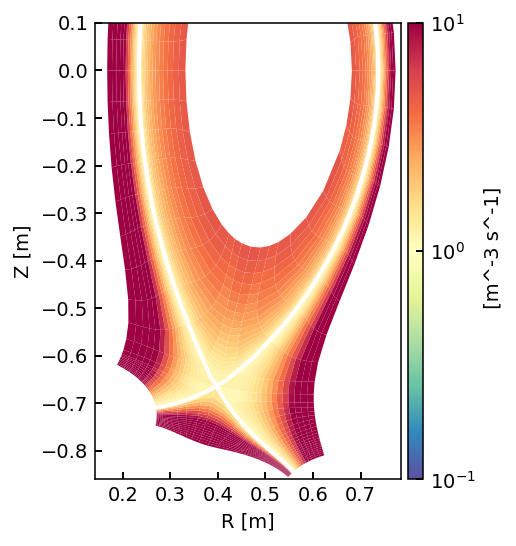

In [68]:
cx_iz_ratio = nu_cx / nu_iz

fig, ax = plt.subplots()

cx_iz_ratio.hermesm.clean_guards().bout.polygon(
    ax = ax, cmap = "Spectral_r", antialias = True,
    # vmin = 1e-1, vmax = 1e1,
    logscale = True)

fig.tight_layout()
ax.set_ylim(-0.86, 0.1)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
# ax.grid(alpha = 1, c = "k", ls = "--")

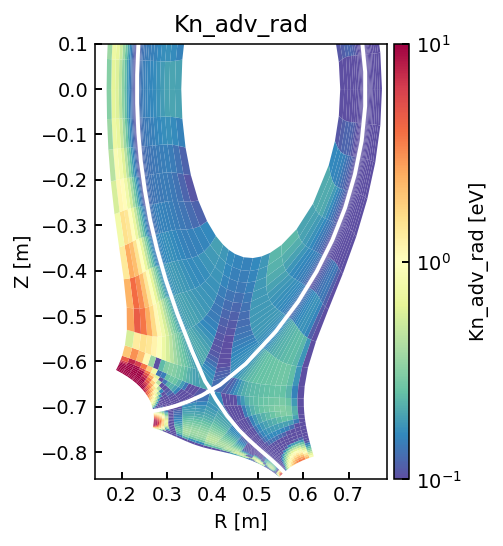

In [66]:
fig, ax = plt.subplots()

ds["Kn_adv_rad"].hermesm.clean_guards().bout.polygon(
    ax = ax, cmap = "Spectral_r", antialias = True,
    vmin = 1e-1, vmax = 1e1,
    logscale = True)

fig.tight_layout()
ax.set_ylim(-0.86, 0.1)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
# ax.grid(alpha = 1, c = "k", ls = "--")

In [23]:
df = get_1d_radial_data_old(ds.isel(t=-1), ["Ne", "dr", "dx"], "omp")



Parameter dx not found


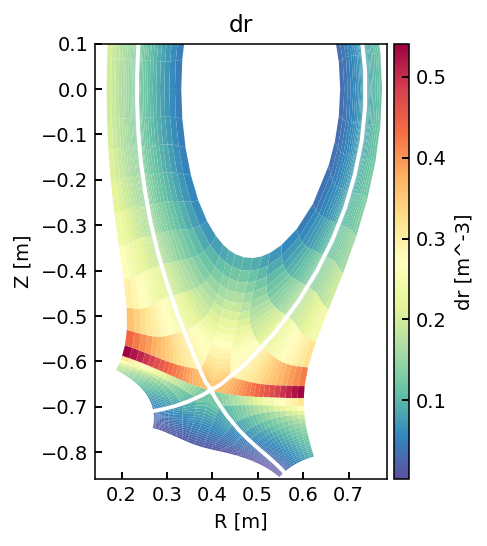

In [ ]:

srad.attrs.meta = ds["Ne"].attrs.copy()

fig, ax = plt.subplots()

srad.hermesm.clean_guards().bout.polygon(
    ax = ax, cmap = "Spectral_r", antialias = True,
    # vmin = 1e-1, vmax = 1e1,
    # logscale = True
    )

fig.tight_layout()
ax.set_ylim(-0.86, 0.1)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

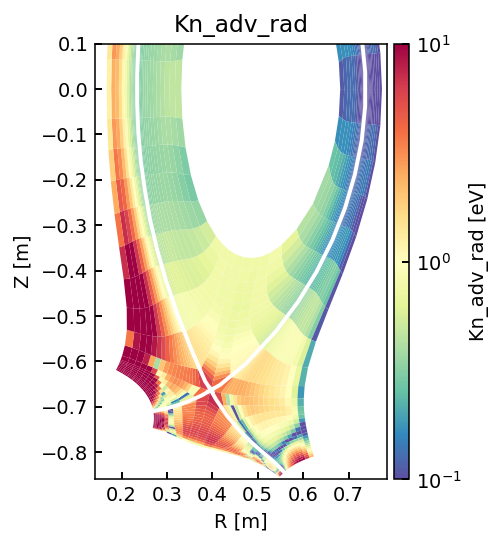